In [1]:
using Pkg; Pkg.DEFAULT_IO[] = stdout; Pkg.activate("."); Pkg.instantiate();

  Activating environment at `~/Research/ToyModel.jl/Project.toml`


In [2]:
Pkg.status()

      Status `~/Research/ToyModel.jl/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.0
  [6fe1bfb0] OffsetArrays v1.10.2
  [91a5bcdd] Plots v1.16.7


In [3]:
using OffsetArrays

L = 2.0
n = 15
dx = L/n

# number of halo points
nh = 2

# a grid with periodic BC
xᶠ = OffsetArray(-nh*dx:dx:L-dx+nh*dx, -nh)
xᶜ = OffsetArray(-nh*dx+dx/2:dx:L-dx/2+nh*dx, -nh);

In [4]:
u₀(x) = sin(2π/L * x)
h₀(x) = cos(4π/L * x);

In [5]:
udata = u₀.(xᶠ)
hdata = h₀.(xᶜ);

In [6]:
∂udata_theoretical =   2π/L * cos.(2π/L * xᶜ)
∂hdata_theoretical = - 4π/L * sin.(4π/L * xᶠ);

In [7]:
udata

19-element OffsetArray(::Vector{Float64}, -1:17) with eltype Float64 with indices -1:17:
 -0.7431448254773941
 -0.40673664307580015
  0.0
  0.40673664307580015
  0.7431448254773941
  0.9510565162951535
  0.9945218953682734
  0.8660254037844387
  0.5877852522924732
  0.20791169081775931
 -0.20791169081775907
 -0.587785252292473
 -0.8660254037844385
 -0.9945218953682733
 -0.9510565162951536
 -0.743144825477394
 -0.40673664307580015
 -2.4492935982947064e-16
  0.4067366430757997

In [8]:
struct Grid
    L
    n
    dx
    xᶠ
    xᶜ
end

grid = Grid(L, n, dx, xᶠ, xᶜ)

Grid(2.0, 15, 0.13333333333333333, -0.26666666666666666:0.13333333333333333:2.1333333333333333 with indices -1:17, -0.2:0.13333333333333333:2.2 with indices -1:17)

In [9]:
faces(grid::Grid) = xᶠ[1:grid.n]
cells(grid::Grid) = xᶜ[1:grid.n];

In [10]:
struct BasicField
    data::AbstractArray
    location::AbstractArray
end

ufield = BasicField(udata, xᶠ)

hfield = BasicField(hdata, xᶜ)

BasicField([0.30901699437494745, 0.9135454576426009, 0.9135454576426009, 0.30901699437494745, -0.4999999999999998, -0.9781476007338057, -0.8090169943749475, -0.10452846326765423, 0.6691306063588585, 1.0, 0.6691306063588589, -0.10452846326765287, -0.8090169943749472, -0.9781476007338055, -0.49999999999999983, 0.309016994374947, 0.9135454576426004, 0.9135454576426009, 0.30901699437494623], -0.2:0.13333333333333333:2.2 with indices -1:17)

In [11]:
using Plots

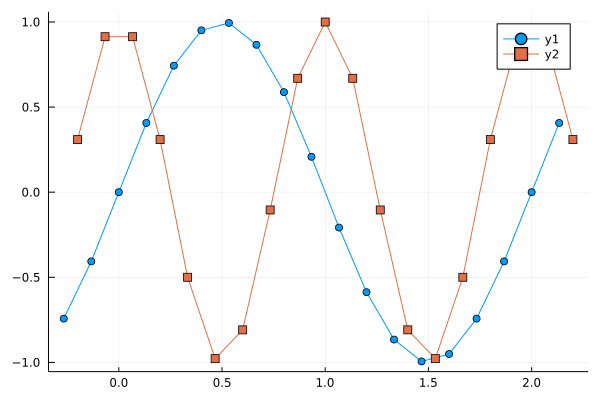

In [12]:
plot(ufield.location, ufield.data, marker=:circle)
plot!(hfield.location, hfield.data, marker=:square)

Btw, we can add a method for `Plots.plot()` :)

In [13]:
import Plots: plot, plot!
Plots.plot(f::BasicField, args...; kwargs...) = plot(f.location, f.data, args...; kwargs...)
Plots.plot!(f::BasicField, args...; kwargs...) = plot!(f.location, f.data, args...; kwargs...)

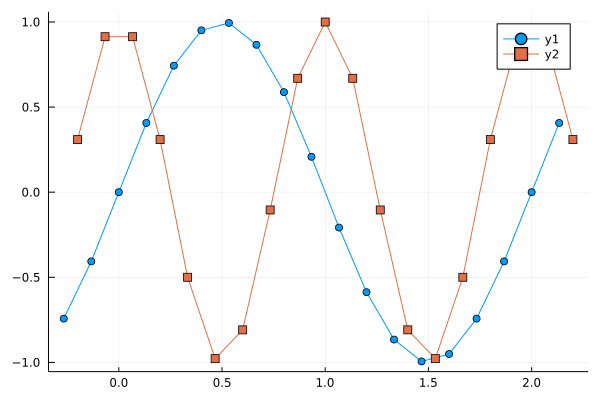

In [14]:
plot(ufield, marker=:circle)
plot!(hfield, marker=:square)

Let's make a better `Field` type that contains the location of the field as parameter.

In [15]:
abstract type AbstractLocation end

In [16]:
struct Cell <: AbstractLocation end 
struct Face <: AbstractLocation end 

In [17]:
struct Field{L<:AbstractLocation, D<:AbstractArray, G}
    data :: D
    grid :: G
    
    Field{L}(data::D, grid::G) where {L, D, G} = new{L, D, G}(data, grid)
end

In [18]:
import Plots: plot, plot!
Plots.plot(f::Field{Face}, args...; kwargs...) = plot(f.grid.xᶠ, f.data, args...; kwargs...)
Plots.plot(f::Field{Cell}, args...; kwargs...) = plot(f.grid.xᶜ, f.data, args...; kwargs...)
Plots.plot!(f::Field{Face}, args...; kwargs...) = plot!(f.grid.xᶠ, f.data, args...; kwargs...)
Plots.plot!(f::Field{Cell}, args...; kwargs...) = plot!(f.grid.xᶜ, f.data, args...; kwargs...)

In [19]:
u = Field{Face}(udata, grid)
h = Field{Cell}(hdata, grid)

Field{Cell, OffsetVector{Float64, Vector{Float64}}, Grid}([0.30901699437494745, 0.9135454576426009, 0.9135454576426009, 0.30901699437494745, -0.4999999999999998, -0.9781476007338057, -0.8090169943749475, -0.10452846326765423, 0.6691306063588585, 1.0, 0.6691306063588589, -0.10452846326765287, -0.8090169943749472, -0.9781476007338055, -0.49999999999999983, 0.309016994374947, 0.9135454576426004, 0.9135454576426009, 0.30901699437494623], Grid(2.0, 15, 0.13333333333333333, -0.26666666666666666:0.13333333333333333:2.1333333333333333 with indices -1:17, -0.2:0.13333333333333333:2.2 with indices -1:17))

Now the types of the fields include information on whether the field lives on cell centers or interfaces. Thus we can write different function methods based on field type.

In [20]:
typeof(u)

Field{Face, OffsetVector{Float64, Vector{Float64}}, Grid}

In [21]:
typeof(h)

Field{Cell, OffsetVector{Float64, Vector{Float64}}, Grid}

Now let's compute derivatives of fields.

In [22]:
δᶜ(i, u) = u[i+1] - u[i]

δᶜ (generic function with 1 method)

In [23]:
δᶠ(i, h) = h[i] - h[i-1]

δᶠ (generic function with 1 method)

In [24]:
δ(i, ψ::Field{<:Cell}) = δᶠ(i, ψ.data)
δ(i, ψ::Field{<:Face}) = δᶜ(i, ψ.data);

In [25]:
δ(3, u)

0.2079116908177594

In [26]:
δ(3, h)

-0.8090169943749472

In [27]:
∂(i, ψ::Field{<:Cell}) = δᶠ(i, ψ.data) / ψ.grid.dx
∂(i, ψ::Field{<:Face}) = δᶜ(i, ψ.data) / ψ.grid.dx;

In [28]:
function ∂_arrays(i, ψ::AbstractArray, grid; location="face")
    if location == "face"
        return δᶜ(i, ψ) / grid.dx
    else
        return δᶠ(i, ψ) / grid.dx
    end
    
end

∂_arrays (generic function with 1 method)

In [29]:
∂udata = similar(udata)

for i in 1:n
    ∂udata[i] = ∂(i, u)
end

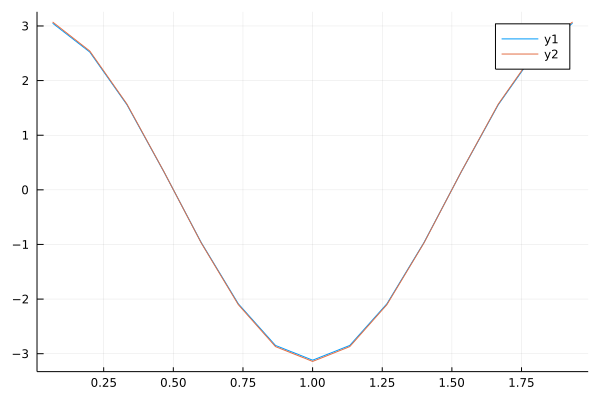

In [30]:
plot(xᶜ[1:n], ∂udata[1:n])
plot!(xᶜ[1:n], ∂udata_theoretical[1:n])

In [31]:
using BenchmarkTools

In [32]:
@btime ∂(10, h);

  37.542 ns (2 allocations: 32 bytes)


In [33]:
@btime ∂_arrays(10, udata, grid; location="cell");

  52.611 ns (3 allocations: 48 bytes)


In [34]:
∂u = Field{Cell}(similar(u.data), grid)
∂h = Field{Face}(similar(h.data), grid)

Field{Face, OffsetVector{Float64, Vector{Float64}}, Grid}([2.1219957915e-314, 2.1219957915e-314, 4.243991583e-314, 6.3659873744e-314, 6.3659873744e-314, 8.4879831653e-314, 8.487983166e-314, 1.0609978957e-313, 1.06099789573e-313, 1.06099789573e-313, 1.2731974749e-313, 1.2731974749e-313, 1.2731974749e-313, 1.48539705397e-313, 1.485397054e-313, 1.485397054e-313, 1.6975966331e-313, 1.69759663317e-313, 2.121995795e-314], Grid(2.0, 15, 0.13333333333333333, -0.26666666666666666:0.13333333333333333:2.1333333333333333 with indices -1:17, -0.2:0.13333333333333333:2.2 with indices -1:17))

In [35]:
function ∂!(∂f::Field, f::Field)
    for i in 1:f.grid.n
        ∂f.data[i] = ∂(i, f)
    end
end;

In [36]:
@btime ∂!(∂u, u)

  1.516 μs (76 allocations: 2.38 KiB)


In [37]:
@btime ∂!(∂h, h)

  1.535 μs (76 allocations: 2.38 KiB)


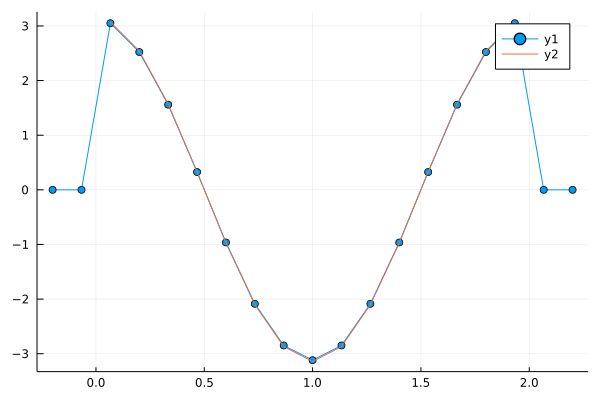

In [38]:
plot(∂u, marker=:circle)
plot!(xᶜ[1:n], ∂udata_theoretical[1:n])

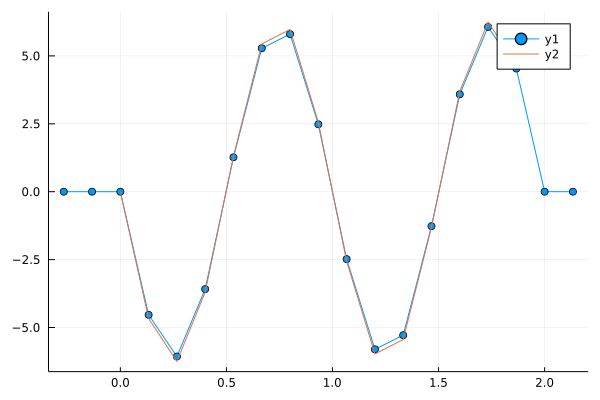

In [39]:
plot(∂h, marker=:circle)
plot!(xᶠ[1:n], ∂hdata_theoretical[1:n])

Can we make it faster?

In [40]:
@inline δᶜ!(δf, i, f) = @inbounds δf[i] = f[i+1] - f[i]
@inline δᶠ!(δf, i, f) = @inbounds δf[i] = f[i] - f[i-1]


function ∂!(∂f::Field{<:Face}, i, f::Field{<:Cell})
    δᶠ!(∂f.data, i, f.data)
    @inbounds ∂f.data[i] /= f.grid.dx
end

function ∂!(∂f::Field{<:Cell}, i, f::Field{<:Face})
    δᶜ!(∂f.data, i, f.data)
    @inbounds ∂f.data[i] /= f.grid.dx
end;

In [41]:
function ∂_better!(∂f::Field, f::Field)
    for i in 1:f.grid.n
        @inbounds ∂!(∂f, i, f)
    end
end;

In [42]:
∂_better!(∂u, u)
∂_better!(∂h, h)

In [43]:
@btime ∂_better!(∂u, u)

  1.651 μs (76 allocations: 2.84 KiB)


In [44]:
@btime ∂_better!(∂h, h)

  1.680 μs (76 allocations: 2.84 KiB)


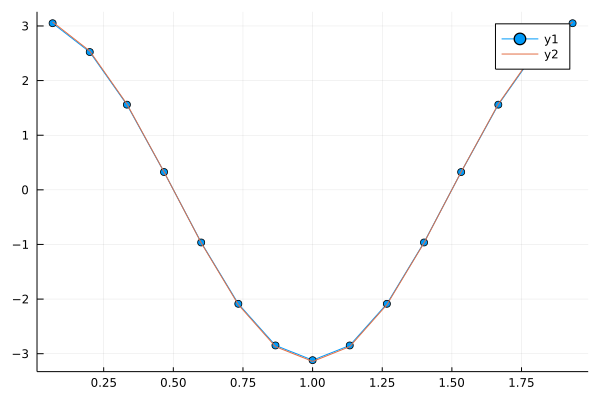

In [45]:
plot(∂u.grid.xᶜ[1:n], ∂u.data[1:n], marker=:circle)
plot!(xᶜ[1:n], ∂udata_theoretical[1:n])

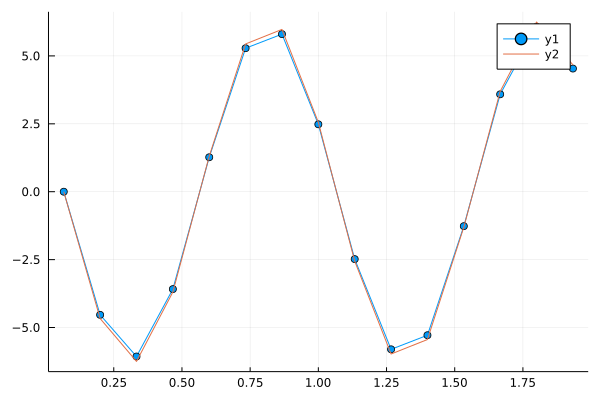

In [46]:
plot(∂h.grid.xᶜ[1:n], ∂h.data[1:n], marker=:circle)
plot!(xᶜ[1:n], ∂hdata_theoretical[1:n])